In [1]:
# tutorial found at https://huggingface.co/docs/transformers/en/model_doc/vit

In [1]:
import torch
from torchvision import transforms
from PIL import Image
from transformers import pipeline
from transformers import AutoImageProcessor, ViTConfig, ViTModel, ViTForImageClassification
from datasets import load_dataset
import matplotlib.pyplot as plt
import numpy as np
import cv2
pipeline = pipeline(
    task="image-classification",
    model="google/vit-base-patch16-224",
    torch_dtype=torch.float16,
    device=0
)

Fast image processor class <class 'transformers.models.vit.image_processing_vit_fast.ViTImageProcessorFast'> is available for this model. Using slow image processor class. To use the fast image processor class set `use_fast=True`.
Device set to use mps:0


In [2]:
# Initializing a ViT vit-base-patch16-224 style configuration
configuration = ViTConfig()

# Initializing a model (with random weights) from the vit-base-patch16-224 style configuration
model = ViTModel(configuration)

# Accessing the model configuration
configuration = model.config

In [34]:

dataset = load_dataset("huggingface/cats-image", trust_remote_code=True)
image = dataset["test"]["image"][0]

image_processor = AutoImageProcessor.from_pretrained("google/vit-base-patch16-224") # resizes and crops the img just picking up the center # FIXME custom the parameters of cropping and of normalization
model = ViTForImageClassification.from_pretrained("google/vit-base-patch16-224")
image_processor.image_mean = [0.3806, 0.4242, 0.3794]
image_processor.image_std = [0.2447, 0.2732, 0.2561]
inputs = image_processor(image, return_tensors="pt")
with torch.no_grad():
    logits = model(**inputs).logits

# model predicts one of the 1000 ImageNet classes
predicted_label = logits.argmax(-1).item()
print(model.config.id2label[predicted_label])

Fast image processor class <class 'transformers.models.vit.image_processing_vit_fast.ViTImageProcessorFast'> is available for this model. Using slow image processor class. To use the fast image processor class set `use_fast=True`.


Egyptian cat


In [35]:
print(model)

ViTForImageClassification(
  (vit): ViTModel(
    (embeddings): ViTEmbeddings(
      (patch_embeddings): ViTPatchEmbeddings(
        (projection): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
      )
      (dropout): Dropout(p=0.0, inplace=False)
    )
    (encoder): ViTEncoder(
      (layer): ModuleList(
        (0-11): 12 x ViTLayer(
          (attention): ViTAttention(
            (attention): ViTSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
            )
            (output): ViTSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.0, inplace=False)
            )
          )
          (intermediate): ViTIntermediate(
            (dense): Linear(in_features=768, out_features=3072, bias=True)
            (intermed

In [ ]:
num_patches = 14**2
layer_dim = 768
out_dim = (num_patches+1) *layer_dim
encoder_blocks = 12
rand_idx = []
for block in range(encoder_blocks):
    rand_idx.append(        np.random.choice(np.arange(out_dim), size=out_dim // 10, replace=False)
    )

In [3]:
def wrapper_hook(layer, rand_idx): # FIXME add randidx
    def hook_func(module, input, output):
        out = output.detach().half().reshape(-1)
        out = out[rand_idx]
        feats[layer].append(
            out
        )  # half makes it become float16, reshape(-1) vectorizes it

    return hook_func
    

In [ ]:
# FIXME add the hooks appropriately
print(model.vit.encoder.layer[1].output) # or .encoder .classifier

In [ ]:
print(model.vit.encoder.layer[0])

In [ ]:
hook_handle = []
# here we are hooking the output of of the 12 transformers blocks 
# they all end with an MLP 768>3072>768 -> importantly, it processes each of the patches indepently and identically
# so the output will be (batch_size, num_tokens, hidden_dim). 
# Leaving aside the batch_size, the tokens (embeddings for the patches) are on the rows, they are (224^2 / 16^2) +1 = 196+1 (the +1 is given by the classification token, a summary of the img)
for block_idx in range(encoder_blocks):
    hook_handle.append(
        model.vit.encoder.layer[block_idx].output.register_forward_hook(
                wrapper_hook(block_idx, rand_idx[block_idx])
            )
        )


In [5]:
#for h in hook_handle:
#    h.remove()

In [42]:
feats = {i: [] for i in range(encoder_blocks)}
with torch.no_grad():
    logits = model(**inputs).logits

# model predicts one of the 1000 ImageNet classes
predicted_label = logits.argmax(-1).item()
print(model.config.id2label[predicted_label])

Egyptian cat


In [43]:
torch.sum(logits)

tensor(0.1885)

In [7]:
path2vid = "/Volumes/TIZIANO/stimuli/Project1917_movie_part3_24Hz.mp4"
reader = cv2.VideoCapture(path2vid)

In [6]:
feats = {i: [] for i in range(encoder_blocks)}
for i in range(1):
    ret, frame = reader.read()
    if ret == False:
        break
    # end if ret==False:

    frame_rgb = cv2.cvtColor(
        frame, cv2.COLOR_BGR2RGB
    )  # converts to bgr to rgb color codes
    inputs = image_processor(frame_rgb, return_tensors="pt")
    

NameError: name 'encoder_blocks' is not defined

In [46]:
print(inputs)

tensor([[[ 1.3133,  0.4158, -0.8182,  ..., -1.3951, -1.3951, -1.3951],
         [-0.0169, -0.7060, -1.0425,  ..., -1.3951, -1.3951, -1.3951],
         [-0.7220, -0.9624, -0.9464,  ..., -1.3951, -1.3951, -1.3951],
         ...,
         [-0.2412, -0.4336, -0.5778,  ..., -1.3791, -1.3791, -1.3791],
         [-0.3855, -0.5457, -0.6739,  ..., -1.3791, -1.3791, -1.3791],
         [-0.5457, -0.5778, -0.6259,  ..., -1.3951, -1.4111, -1.3951]],

        [[ 1.2320,  0.4282, -0.6627,  ..., -1.3230, -1.3230, -1.3230],
         [ 0.0406, -0.5766, -0.8637,  ..., -1.3230, -1.3230, -1.3230],
         [-0.5910, -0.8063, -0.7919,  ..., -1.3230, -1.3230, -1.3230],
         ...,
         [-0.3613, -0.5336, -0.6627,  ..., -1.3661, -1.3661, -1.3661],
         [-0.4905, -0.6340, -0.7489,  ..., -1.3661, -1.3661, -1.3661],
         [-0.6340, -0.6627, -0.7058,  ..., -1.3517, -1.3517, -1.3517]],

        [[ 1.3361,  0.4786, -0.7005,  ..., -1.2824, -1.2824, -1.2824],
         [ 0.0498, -0.6239, -0.9302,  ..., -1

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


torch.Size([224, 224, 3])


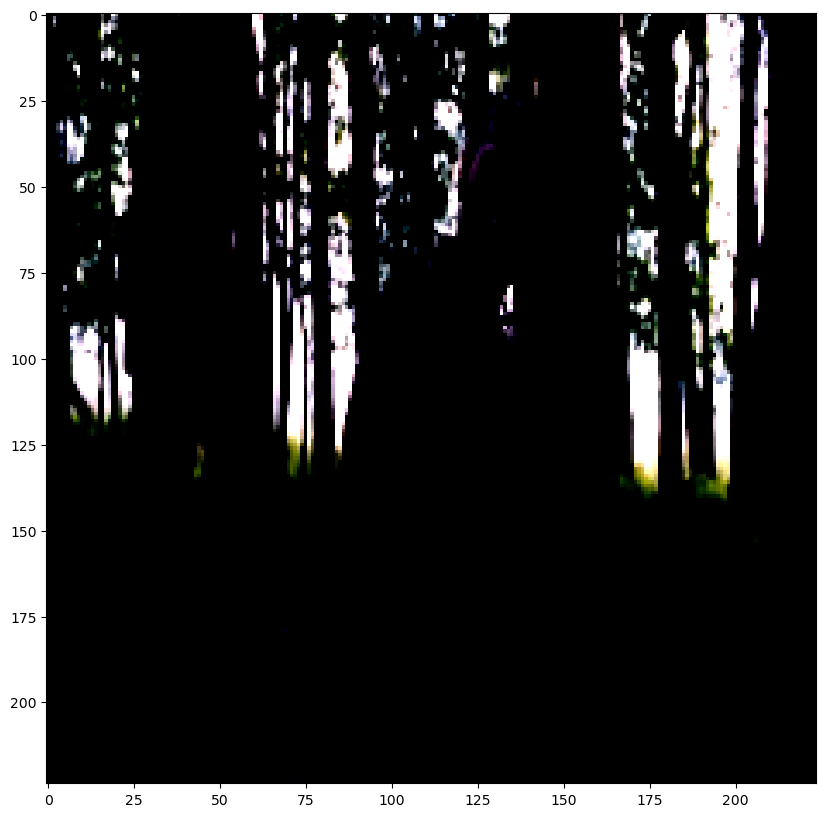

In [47]:
plt.figure(figsize=(10,10))
inputs_1 = image_processor(frame_rgb, return_tensors="pt")
img2plot1 = inputs_1["pixel_values"][0,:,:,:].permute(1,2,0)
plt.imshow(img2plot1)
print(torch.Tensor.size(img2plot1))


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


torch.Size([224, 224, 3])


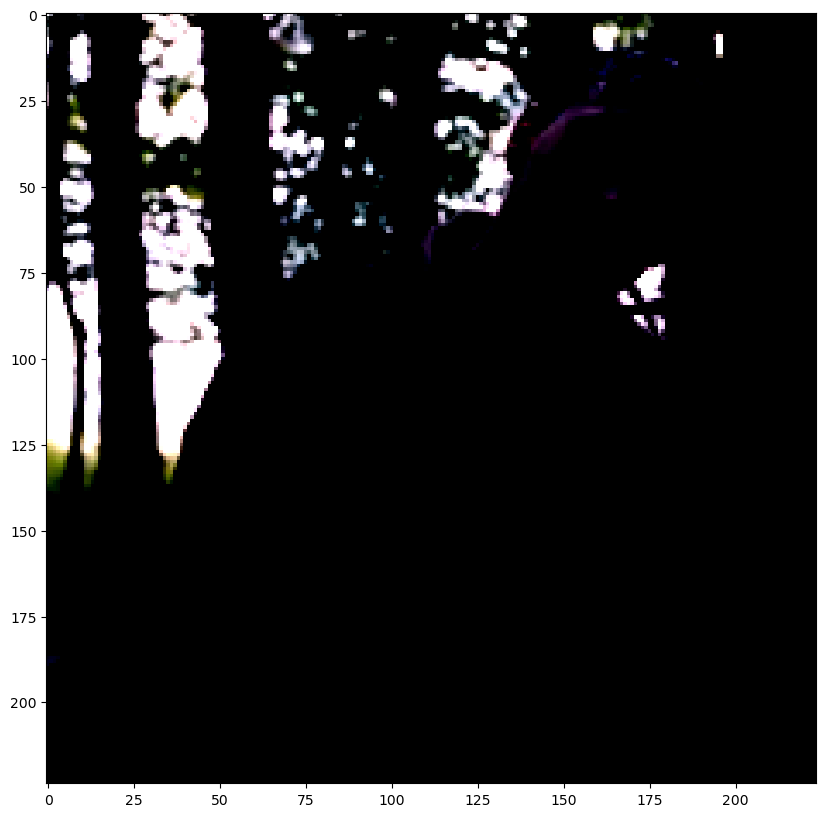

In [31]:
plt.figure(figsize=(10,10))
img_frame = Image.fromarray(frame_rgb)
inputs = custom_transform(img_frame)
img2plot2 = inputs.permute(1,2,0)
plt.imshow(img2plot2)
print(torch.Tensor.size(img2plot2))

In [21]:
print(inputs)

{'pixel_values': tensor([[[[-0.6863, -0.5922, -0.6000,  ..., -0.9059, -0.8824, -0.8902],
          [-0.6941, -0.6235, -0.0353,  ..., -0.9137, -0.8980, -0.8902],
          [-0.7333, -0.7020,  0.0902,  ..., -0.9216, -0.9059, -0.8980],
          ...,
          [-0.5529, -0.4745, -0.4588,  ..., -0.5216, -0.5686, -0.6000],
          [-0.5294, -0.4824, -0.4980,  ..., -0.5451, -0.5608, -0.6000],
          [-0.5373, -0.5059, -0.5451,  ..., -0.5686, -0.5608, -0.6000]],

         [[-0.6235, -0.4745, -0.4745,  ..., -0.8824, -0.8667, -0.8745],
          [-0.6314, -0.5059,  0.0902,  ..., -0.8980, -0.8745, -0.8745],
          [-0.6706, -0.5922,  0.2078,  ..., -0.9059, -0.8824, -0.8824],
          ...,
          [-0.5137, -0.4275, -0.4353,  ..., -0.4980, -0.5529, -0.5843],
          [-0.4902, -0.4431, -0.4667,  ..., -0.5216, -0.5373, -0.5843],
          [-0.4980, -0.4588, -0.5137,  ..., -0.5451, -0.5373, -0.5765]],

         [[-0.6941, -0.5451, -0.5216,  ..., -0.8902, -0.8745, -0.8824],
          [-0